In [11]:
import pandas as pd
import numpy as np
import cv2  # for image processing
import scipy.io
import os
from arts_preprocess_utils import load_dataset, get_image
import scipy
#from scipy.spatial.distance import directed_hausdorff, cosine
from IPython import display
%matplotlib inline
import matplotlib.pyplot as plt

In [4]:
import zipfile

#dataset from Kaggle
filezip = zipfile.ZipFile('/root/work/datasets/train.zip', 'r')

## Load Artwork

In [5]:
#Artwork metadata

df_artworks = pd.read_csv('/root/work/datasets/train_mayors_style_encoded.csv')
df_artworks.head()

,filename,title,style,genre,date,artist,code
0,70944.jpg,Forbidden Land,Surrealism,landscape,1937.0,Wolfgang Paalen,[ 1.16539335e+00 1.28991747e+00 1.7878958...
1,99442.jpg,Storm at sea,Romanticism,marina,1873,Ivan Aivazovsky,[ 0.05018258 0.6800102 1.09940994 0.763883...
2,28908.jpg,Yachting in the Mediterranean,Realism,genre painting,1896,Julius LeBlanc Stewart,[ -3.45420241e-02 9.70972657e-01 1.3141356...
3,7486.jpg,Death of Eleazer,Romanticism,religious painting,1866,Gustave Dore,[ 3.87025893e-01 2.29165435e-01 8.3127570...
4,35766.jpg,The-Deluge,Romanticism,religious painting,NaN,Gustave Dore,[ 8.99345875e-02 -3.33367102e-02 1.1803588...


In [6]:
#Artwork codes

artwork_code_matrix = np.load('/root/work/datasets/train_mayors_style_encode.npy')
artwork_code_matrix.shape

(46010, 300)

**Artwork pivot**

In [7]:
df_monet = df_artworks[df_artworks['artist'] == 'Claude Monet']
df_monet.head(10)

,filename,title,style,genre,date,artist,code
80,49757.jpg,"The Manneport, Rock Arch West of Etretat",Impressionism,landscape,1883,Claude Monet,[-0.03906703 0.3938542 1.42708027 0.692869...
255,41682.jpg,"Poppy Field, Argenteuil",Impressionism,landscape,1875,Claude Monet,[ -1.10783331e-01 1.14417470e+00 1.0160129...
256,37256.jpg,Gardener's House at Antibes,Impressionism,landscape,1888,Claude Monet,[ 0.54551548 0.5936197 1.50468051 0.518604...
293,56641.jpg,Sunlight Effect under the Poplars,Impressionism,landscape,1887,Claude Monet,[ 0.36027062 -0.07704699 1.07489741 0.968056...
304,52850.jpg,"Rouen Cathedral, the Portal, Morning Effect",Impressionism,cityscape,1894,Claude Monet,[ 1.74061906e+00 6.82920814e-01 6.8371206...
313,97356.jpg,The?Allee?du Champ?de Foire?at Argenteuil,Impressionism,landscape,1874,Claude Monet,[ 0.06250456 0.50736952 0.86784828 0.706576...
442,52023.jpg,Haystack at Giverny,Impressionism,landscape,1886,Claude Monet,[-0.36644974 -0.00670185 0.78091192 0.617322...
578,16139.jpg,Vetheuil,Impressionism,landscape,1879,Claude Monet,[ -1.70502976e-01 4.98518407e-01 1.1815836...
627,61167.jpg,Camille Monet and a Child in the Artist?s Gard...,Impressionism,portrait,1875,Claude Monet,[ 0.07912862 0.00962067 1.20411205 0.918237...
638,11233.jpg,Rouen Cathedral,Impressionism,cityscape,1893,Claude Monet,[ 6.21454358e-01 3.11560929e-01 1.6615829...


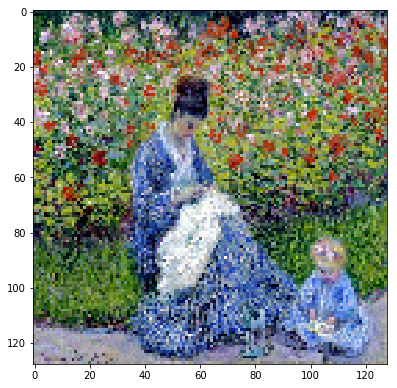

In [24]:
#Plot image
img_path = filezip.extract('train/' + df_monet['filename'][627])
image = get_image(img_path)

fig = plt.gcf()
fig.set_size_inches(14.5, 6.5)

plt.imshow(image[0][...,::-1])

In [26]:
fig.savefig('./image_result/query.jpg')

In [14]:
code_image = artwork_code_matrix[627]

## Get similar artworks 

In [15]:
from sklearn.metrics.pairwise import cosine_similarity

sim_matrix = cosine_similarity(code_image.reshape((1,-1)), artwork_code_matrix)

In [16]:
sim_matrix.shape

(1, 46010)

In [17]:
index_sorted = np.argsort(sim_matrix)

In [18]:
top_ten = index_sorted[0][-11:-1]

**Get top ten metadata**

In [19]:
df_top_ten = df_artworks.iloc[top_ten]
df_top_ten

,filename,title,style,genre,date,artist,code
1629,36143.jpg,Portrait of a Lady,Symbolism,portrait,c.1917,Gustav Klimt,[ -1.45667791e-02 1.30318356e+00 4.1592571...
42792,45640.jpg,Leela Wend,Art Nouveau (Modern),genre painting,NaN,Wilhelm Kotarbinski,[ -1.30654154e-02 2.05519199e-02 6.0000783...
31207,2821.jpg,Self-Portrait with Hand under Cheek,Expressionism,self-portrait,NaN,Edvard Munch,[ 0.38479751 -0.01265285 0.5375582 0.784861...
41016,1709.jpg,The Harlot of Jericho and the Two Spies,Symbolism,religious painting,c.1902,James Tissot,[ -1.63036913e-01 8.75612617e-01 6.4728593...
36229,90161.jpg,Triton,Baroque,sketch and study,NaN,Annibale Carracci,[ 0.7598989 0.37039387 0.81916106 1.219913...
31135,26765.jpg,Reclining female nude,Realism,nude painting (nu),NaN,Theophile Steinlen,[ -1.36655150e-02 3.51030827e-01 8.5509109...
37262,5322.jpg,Vase. Celery stalks design,Art Nouveau (Modern),design,1914.0,Louis Comfort Tiffany,[ -2.79908150e-01 4.72204447e-01 9.6320009...
42479,97488.jpg,The Orgy,Expressionism,figurative,1973.0,Walter Battiss,[ -5.04996777e-02 4.53837335e-01 8.3607351...
2488,26242.jpg,Park,Art Nouveau (Modern),landscape,1910,Gustav Klimt,[ 0.64760196 0.37011808 0.80473351 0.765274...
6945,81526.jpg,Water Lilies,Impressionism,flower painting,1908,Claude Monet,[ -5.45881502e-02 4.02260244e-01 8.7641060...


**Plot artworks**

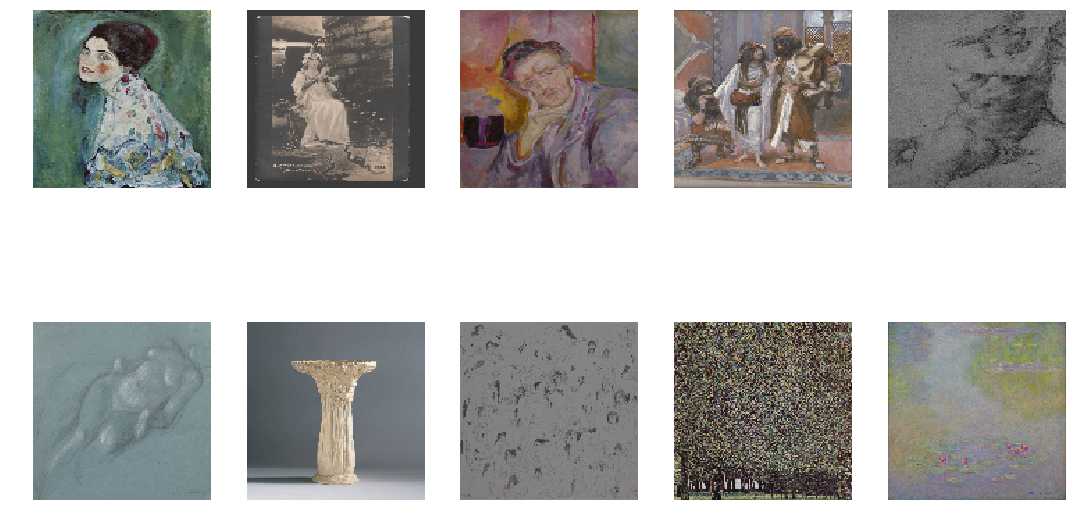

In [20]:
r, c = 2, 5
cnt= 0

relative_path = list(df_top_ten['filename'])
fig, axs = plt.subplots(r, c)

for i in range(r):
    for j in range(c):
        img_path = filezip.extract('train/' + relative_path[cnt])
        axs[i,j].imshow(get_image(img_path)[0][...,::-1])
        axs[i,j].axis('off')
        cnt += 1

fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)

plt.show()


In [22]:
fig.savefig('./image_result/query_result.jpg')